### Setup for data loading

In [1]:
import cv2
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F  # useful stateless functions

from matplotlib.pyplot import plot, xlabel, ylabel, title, imshow
from matplotlib import pyplot as plt

import numpy as np
import random

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [91]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

using device: cuda


### Loading human detection training data

In [3]:
# Load human detection training data.
# Each human sample is stored as lists of
# bbox[iClip][iFrame] = narray(N,D)
# where N = number of people in the frame, and 
# D = 4 (x, y, width, height)
hf = h5py.File('truth_data/ground_truth_data_train.mat', 'r')
data = hf.get('ground_truth_data')['list']
bbox = {}
for d in data[0]:
    imgname = ''.join([chr(x) for x in hf[d]['imgname'][:]])
    iClip = imgname[4:7]
    iFrame = imgname[8:12]
    if iClip not in bbox:
        bbox[iClip] = {}
    bbox[iClip][iFrame] = np.int_(hf[d]['bbox'][:].T/6)

In [4]:
# Check number of human dectection samples.
nData = 0
for iClip in bbox:
    for iFrame in bbox[iClip]:
        nData += bbox[iClip][iFrame].shape[0]
nData

1607

### Video data loading

In [5]:
# Save corresponding clips
path = 'videos/'
frames = {}
for iClip in bbox:
    videofile = path+'mv2_'+iClip+'.avi'
    cap = cv2.VideoCapture(videofile)
    frames[iClip] = {}
    for iFrame in bbox[iClip]:
        cap.set(1, int(iFrame))
        ret, frame = cap.read()
        if ret:
            frame = torch.from_numpy(frame)
            frames[iClip][iFrame] = frame

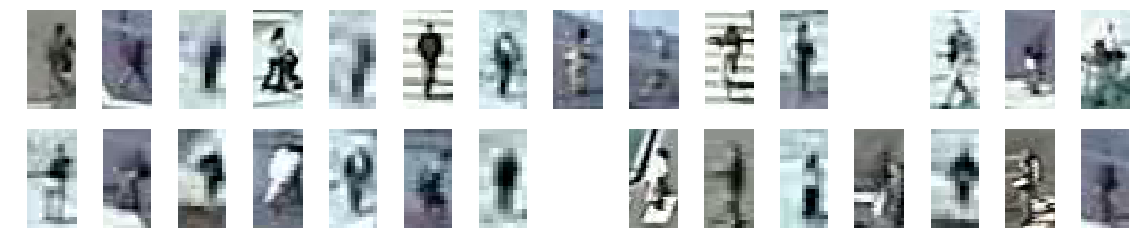

In [6]:
# Random sanity check
fig = plt.figure(figsize=(20,4))
for i in range(30):
    ax = fig.add_subplot(2,15,i+1)
    ax.axis('off')
    iClip = random.choice(list(bbox.keys()))
    iFrame = random.choice(list(bbox[iClip].keys()))
    try:
        x,y,w,h = bbox[iClip][iFrame][0]
        ax.imshow(frames[iClip][iFrame][y:y+h, x:x+w, :])
    except:
        continue

### Training data with still images
First, we will try training the data with still images of a person. Since the images of a person in the training data are not equal, we try 1) crop/zero-padding the image to equal size, or 2) scale the image.

In [117]:
# Generating train data. All images are cropped to (15,30).
# True data
X_sample = torch.zeros(nData,3,15,30)
y_sample = torch.zeros(nData, )
i = 0
for iClip in bbox:
    for iFrame in bbox[iClip]:
        for d in bbox[iClip][iFrame]:
            try:
                x, y, w, h = d
                x -= int((w-15)/2)
                y -= int((h-30)/2)
                data = frames[iClip][iFrame][x:x+15, y:y+30,:].to(dtype=torch.float32)
                X_sample[i,:,:,:] = torch.unsqueeze(data.permute(2,0,1),0)
                y_sample[i] = 1
                i += 1
            except:
                continue
X_sample = X_sample[:i,]
y_sample = y_sample[:i,]

In [118]:
# False data are randomly sampled from images.
n = X_sample.shape[0]
for i in range(n):
    iClip = random.choice(list(bbox.keys()))
    iFrame = random.choice(list(bbox[iClip].keys()))
    x = int(random.random()*705)
    y = int(random.random()*450)
    try:
        data = frames[iClip][iFrame][x:x+15, y:y+30,:].to(dtype=torch.float32)
        X_sample = torch.cat((X_sample,torch.unsqueeze(data.permute(2,0,1),0)),0)
        y_sample = torch.cat((y_sample, torch.zeros(1)))
    except:
        continue

In [119]:
N = X_sample.shape[0]
N_train = int(N*.8)
mask = list(range(N))
random.shuffle(mask)
X_train = X_sample[mask[:N_train],]
X_val = X_sample[mask[N_train:],]
y_train = y_sample[mask[:N_train],]
y_val = y_sample[mask[N_train:],]

In [92]:
# Train CNN
model = nn.Sequential(
    nn.Conv2d(3, 32, 5, padding=2),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    Flatten(),
    nn.Linear(16*15*30, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
)
optimizer = optim.Adam(model.parameters(), lr=2.e-4, betas=(0.9, 0.999))

In [28]:
# Need to fix

def check_accuracy(X, y, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

def train_model(X, y, model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    N = X.shape[0]
    t = 0
    for e in range(epochs):
        for i in range(int(N/epochs)):
            scores = model(X[t])
            loss = F.cross_entropy(scores, y[t])

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
        
            t += 1
            if t % 100 == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

array([[2880.],
       [4320.]])

<HDF5 dataset "imgsize": shape (2, 1), type "<f8">
